In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "../dataset/Fintech_EDA.csv"   # ruta al CSV

df = pd.read_csv(DATA_PATH, sep=",", encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403535 entries, 0 to 403534
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id_comercio                403535 non-null  int64  
 1   company_created_at         403535 non-null  object 
 2   categoria                  403535 non-null  object 
 3   is_taxpayer                403535 non-null  bool   
 4   tipo_comercio              403535 non-null  object 
 5   banco_afiliacion_comercio  403142 non-null  object 
 6   id_transaccion             403535 non-null  int64  
 7   monto                      403535 non-null  int64  
 8   currency_iso               403535 non-null  object 
 9   tipo_transaccion           403535 non-null  object 
 10  modo_lectura               348731 non-null  object 
 11  pos_id                     348731 non-null  float64
 12  transaction_created_at     403535 non-null  object 
 13  lat                        34

In [3]:
#Seleccionar solo las columnas de interes
cols_interes = ['id_comercio','transaction_created_at','monto_usd']
df_transacciones = df[cols_interes]
df_transacciones

,id_comercio,transaction_created_at,monto_usd
0,21981,2025-08-01 12:16:08,74.34
1,21981,2025-08-01 00:06:16,74.34
2,21981,2025-08-01 22:16:34,62.56
3,21981,2025-08-01 07:25:28,59.43
4,21981,2025-08-01 00:07:54,74.34
...,...,...,...
403530,29480,2025-10-31 23:57:44,10.42
403531,10955,2025-10-31 23:58:09,20.00
403532,46693,2025-10-31 23:58:30,4.95
403533,44094,2025-10-31 23:59:28,5.00


## Experimento 1 - Usar columna monto original convertida en dolares

In [4]:
# 2. Agregación: Calcular el Monto Total (Monto_M) por cada empresa
df_segmentacion_1 = df_transacciones.groupby('id_comercio')['monto_usd'].sum().reset_index()
df_segmentacion_1.columns = ['Empresa', 'Monto_Total']

# Convertir a DataFrame de NumPy (para sklearn) y renombrar
X = df_segmentacion_1[['Monto_Total']]

print("\nMuestra de datos Agregados por Empresa:")
print(X.head())


Muestra de datos Agregados por Empresa:
   Monto_Total
0          9.0
1         18.0
2        503.0
3         10.0
4         96.0


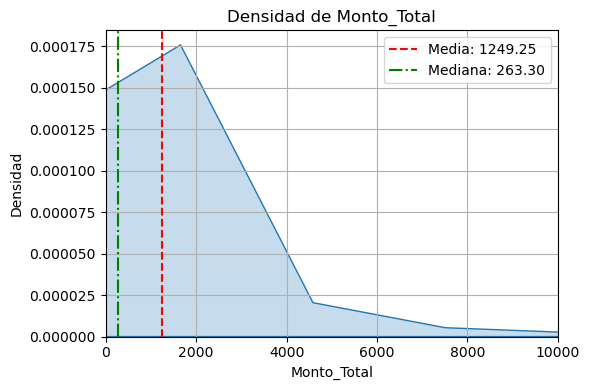

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

def graficar_kde_hist(df, num_vars,limite_x=0):
  # Análisis de comportamiento gráfico
  # KDE plot para variables numéricas
  # Itera por cada variable numérica del dataset
  for var in num_vars:
      # Calcula la media y mediana de esa variable
      media = df[var].mean()
      mediana = df[var].median()

      # Crea un gráfico KDE con Seaborn, ignorando los valores nulos.
      # El área bajo la curva se rellena para mayor claridad visual.
      plt.figure(figsize=(6, 4))
      sns.kdeplot(df[var].dropna(), fill=True)

      #Establecer limite eje X
      if(limite_x > 0):
          plt.xlim(0, limite_x)

      # Dibuja dos líneas verticales: una roja punteada para la media
      # otra verde con puntos y guiones para la mediana, con etiquetas.
      plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
      plt.axvline(mediana, color='green', linestyle='-.',label=f'Mediana: {mediana:.2f}')

      # Añade título, etiquetas, grilla, leyenda y muestra el gráfico
      # con un ajuste automático de márgenes.
      plt.title(f'Densidad de {var}')
      plt.xlabel(var)
      plt.ylabel('Densidad')
      plt.grid(True)
      plt.legend()
      plt.tight_layout()
      plt.show()
      
graficar_kde_hist(df_segmentacion_1, ['Monto_Total'],10000)

In [15]:
# 3. Estandarización (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X_scaled es un array de NumPy
print("\nDatos Estandarizados (Primeras 5 filas):")
print(X_scaled[:5])


Datos Estandarizados (Primeras 5 filas):
[[-0.13503116]
 [-0.13405129]
 [-0.08124722]
 [-0.13492228]
 [-0.12555909]]


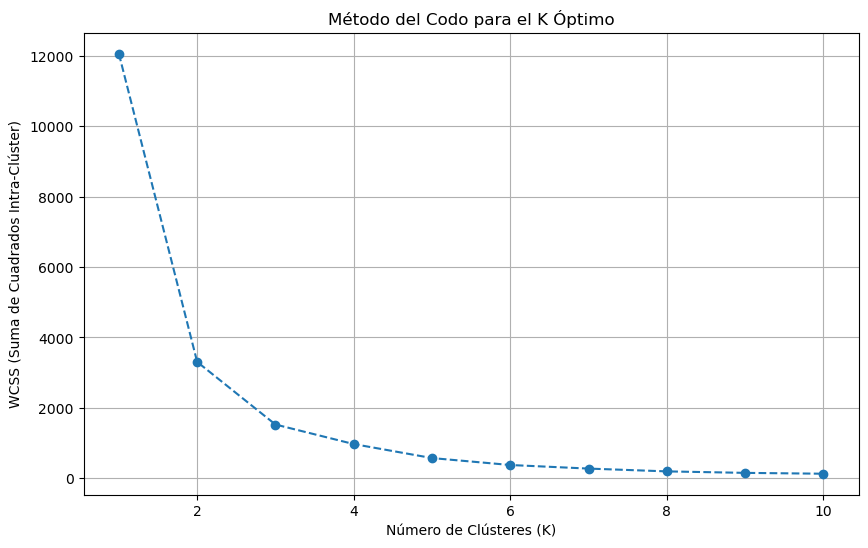

In [25]:
# 4. Método del Codo para encontrar K óptimo
def graficar_metodo_codo(X_scaled):
    wcss = []
    k_range = range(1, 11) # Probar K desde 1 hasta 10
    
    # Entrenar K-means para cada valor de K y calcular WCSS
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_) # 'inertia_' es la métrica WCSS
    
    # Gráfico del Método del Codo
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wcss, marker='o', linestyle='--')
    plt.title('Método del Codo para el K Óptimo')
    plt.xlabel('Número de Clústeres (K)')
    plt.ylabel('WCSS (Suma de Cuadrados Intra-Clúster)')
    plt.grid(True)
    plt.show()

graficar_metodo_codo(X_scaled)

In [29]:
# 5. Aplicar K-means con el K óptimo (asumiendo K=4)
def aplicar_kmeans(k_optimo, X_scaled, df_segmentacion):
    kmeans_final = KMeans(n_clusters=k_optimo, init='k-means++', max_iter=300, n_init=10, random_state=42)
    clusters = kmeans_final.fit_predict(X_scaled)
    
    # Asignar los resultados al DataFrame original
    df_segmentacion['Segmento'] = clusters
    
    # 6. Análisis de los Segmentos (Interpretación)
    # Calcular los Centroides (medias de cada clúster) en la escala original
    
    # Desestandarizar los centroides para interpretarlos en la moneda real
    centroides_escalados = kmeans_final.cluster_centers_
    centroides_reales = scaler.inverse_transform(centroides_escalados)
    
    # Crear un DataFrame de Centroides
    df_centroides = pd.DataFrame(centroides_reales, columns=['Monto_Total_Promedio'])
    df_centroides['Segmento'] = range(k_optimo)
    df_centroides = df_centroides.sort_values(by='Monto_Total_Promedio', ascending=False).reset_index(drop=True)
    
    print("\n--- Resultados de Segmentación ---")
    print("\nCentroides de los Clústeres (Monto Total Promedio en la moneda original):")
    print(df_centroides)
    
    print("\nConteo de Empresas por Segmento:")
    print(df_segmentacion['Segmento'].value_counts().sort_index())
    
    print("\nEmpresas con su Segmento Asignado:")
    print(df_segmentacion.head())

aplicar_kmeans(4,X_scaled,df_segmentacion_1)


--- Resultados de Segmentación ---

Centroides de los Clústeres (Monto Total Promedio en la moneda original):
   Monto_Total_Promedio  Segmento
0         451021.153333         1
1         188755.032500         2
2          14674.839512         3
3            728.063303         0

Conteo de Empresas por Segmento:
Segmento
0    11801
1        3
2        8
3      249
Name: count, dtype: int64

Empresas con su Segmento Asignado:
   Empresa  Monto_Total  Segmento
0        5          9.0         0
1       22         18.0         0
2       63        503.0         0
3       75         10.0         0
4       78         96.0         0


C:\Users\marlo\AppData\Local\Temp\ipykernel_21576\1631814537.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segmento', y='Monto_Total', data=df_segmentacion_1, palette='viridis')


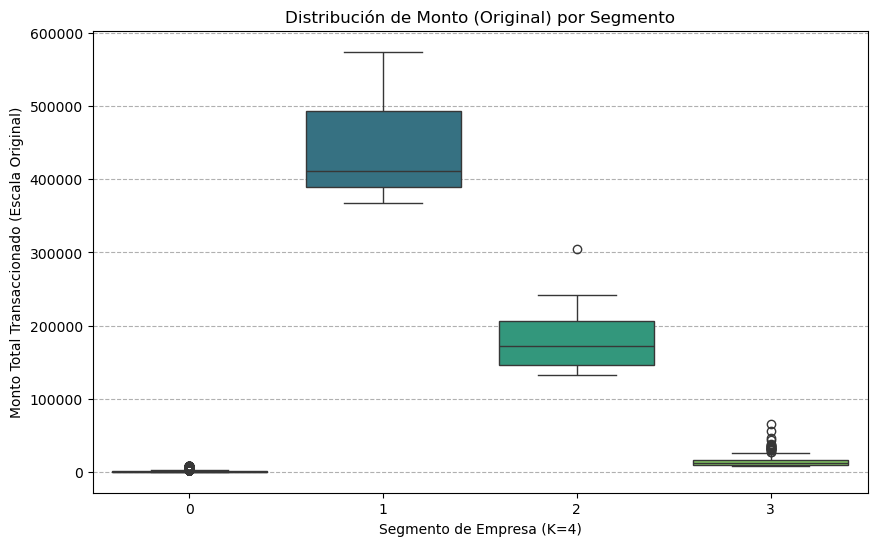

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Graficar clustering
# Configuración: Asumimos k_optimo = 4 y los centroides están desestandarizados.
k_optimo = df_segmentacion_1['Segmento'].nunique()
plt.figure(figsize=(10, 6))
# Usamos la variable transformada (Monto_Log) para ver la distribución real que usó K-means
sns.boxplot(x='Segmento', y='Monto_Total', data=df_segmentacion_1, palette='viridis')

plt.title('Distribución de Monto (Original) por Segmento')
plt.xlabel(f'Segmento de Empresa (K={k_optimo})')
plt.ylabel('Monto Total Transaccionado (Escala Original)')
plt.grid(axis='y', linestyle='--')
plt.show()

## Experimento 2 - Usar columna monto transformada logaritmicamente

In [37]:
# 2. Agregación: Calcular el Monto Total (Monto_M) por cada empresa
df_segmentacion_2 = df_transacciones.groupby('id_comercio')['monto_usd'].sum().reset_index()
df_segmentacion_2.columns = ['Empresa', 'Monto_Total']

#  Transformación Logarítmica para manejar el Sesgo
# Aplicar log(x + 1) a la variable Monto_Total
df_segmentacion_2['Monto_Log'] = np.log1p(df_segmentacion_2['Monto_Total'])
# np.log1p es el atajo de NumPy para log(x + 1)

# Convertir a DataFrame de NumPy (para sklearn) y renombrar
X = df_segmentacion_2[['Monto_Log']]

print("\nMuestra de datos Agregados por Empresa:")
print(X.head())


Muestra de datos Agregados por Empresa:
   Monto_Log
0   2.302585
1   2.944439
2   6.222576
3   2.397895
4   4.574711


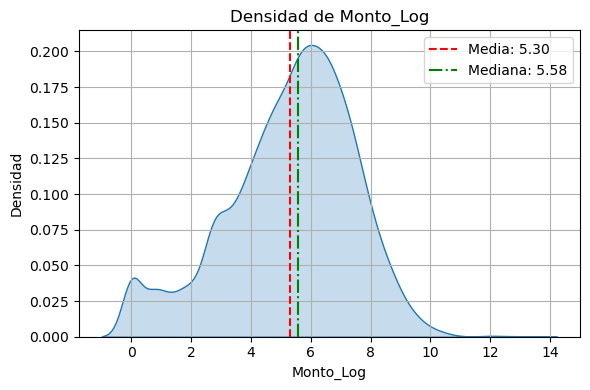

In [41]:
graficar_kde_hist(df_segmentacion_2, ['Monto_Log'])

In [43]:
# 3. Estandarización (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X_scaled es un array de NumPy
print("\nDatos Estandarizados (Primeras 5 filas):")
print(X_scaled[:5])


Datos Estandarizados (Primeras 5 filas):
[[-1.40214369]
 [-1.10194285]
 [ 0.43127149]
 [-1.35756626]
 [-0.33944995]]


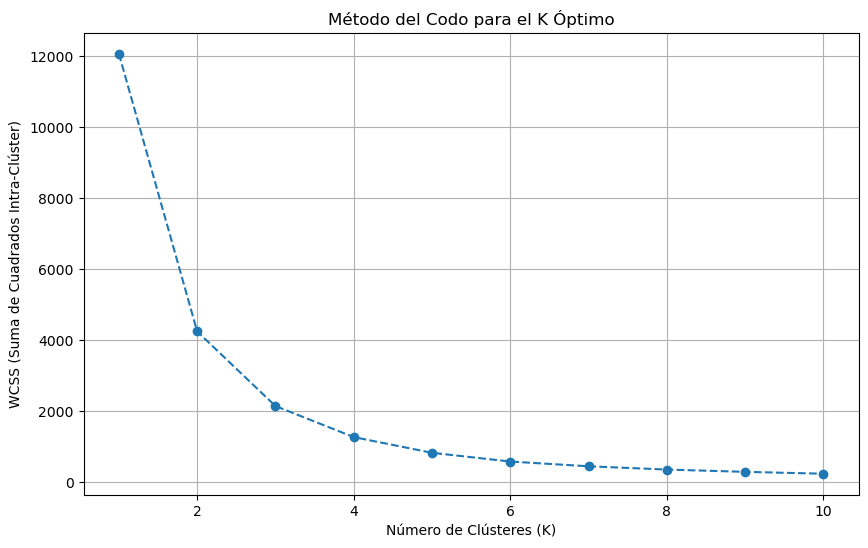

In [45]:
graficar_metodo_codo(X_scaled)

In [47]:
aplicar_kmeans(4,X_scaled,df_segmentacion_2)


--- Resultados de Segmentación ---

Centroides de los Clústeres (Monto Total Promedio en la moneda original):
   Monto_Total_Promedio  Segmento
0              7.742276         2
1              5.800966         1
2              3.730888         3
3              0.937493         0

Conteo de Empresas por Segmento:
Segmento
0    1154
1    4694
2    3086
3    3127
Name: count, dtype: int64

Empresas con su Segmento Asignado:
   Empresa  Monto_Total  Monto_Log  Segmento
0        5          9.0   2.302585         0
1       22         18.0   2.944439         3
2       63        503.0   6.222576         1
3       75         10.0   2.397895         3
4       78         96.0   4.574711         3


C:\Users\marlo\AppData\Local\Temp\ipykernel_21576\324853806.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segmento', y='Monto_Log', data=df_segmentacion_2, palette='viridis')


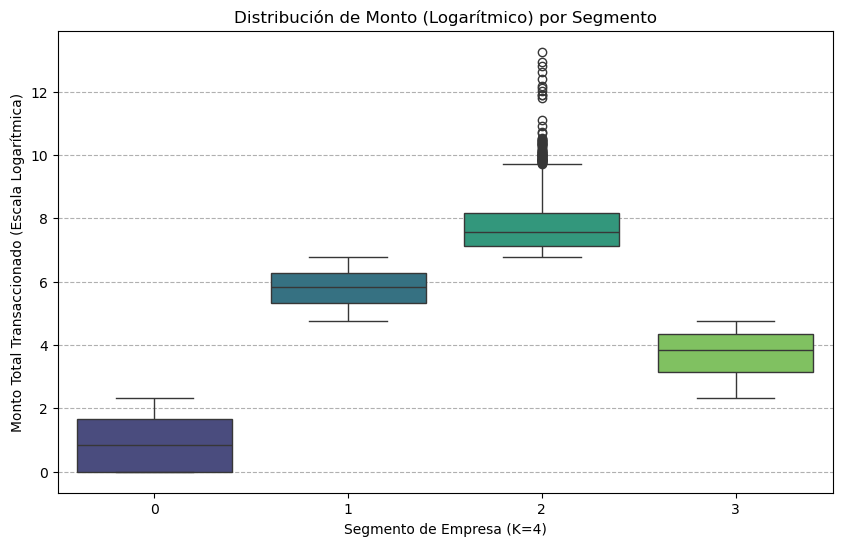

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Graficar clustering
# Configuración: Asumimos k_optimo = 4 y los centroides están desestandarizados.
k_optimo = df_segmentacion_2['Segmento'].nunique()
plt.figure(figsize=(10, 6))
# Usamos la variable transformada (Monto_Log) para ver la distribución real que usó K-means
sns.boxplot(x='Segmento', y='Monto_Log', data=df_segmentacion_2, palette='viridis')

plt.title('Distribución de Monto (Logarítmico) por Segmento')
plt.xlabel(f'Segmento de Empresa (K={k_optimo})')
plt.ylabel('Monto Total Transaccionado (Escala Logarítmica)')
plt.grid(axis='y', linestyle='--')
plt.show()